# YOLO12 Instance Segmentation Training and Inference Notebook

This notebook is a simple example of how to pull your exported object detection dataset from Oslo and train a YOLO11-Seg model using the Ultralytics library.

You need to have the following information to run this notebook:

- `project_identifier`: The identifier of the project you want to use, you can find this on the project page in Oslo.
- `access_token`: Your personal access token, you can find this in your organization settings in Oslo.
- `version`: The version of the dataset you want to use, you can find this on the exports page in Oslo.

It is a good idea to check that you have GPU available first.



In [1]:
!nvidia-smi

Sun Mar  2 19:45:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8              7W /  165W |     620MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencies for YOLOV12

Note: At the time of writing you need to have pytorch>=2.2 compiled with CUDA support (12.8) for the flash-attn to install properly.

In [2]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git flash-attn 

In [3]:
!pip3 install -U ultralytics

import ultralytics as ul
ul.checks()

import os

HOME = os.getcwd()
print("HOME:", HOME)

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
Setup complete ✅ (24 CPUs, 30.5 GB RAM, 410.9/767.9 GB disk)
HOME: /home/pyrat/projects/training-notebooks/notebooks


In [ ]:
!pip3 install -U oslovision

from oslovision import OsloVision

project_identifier = "[YOUR_PROJECT_IDENTIFIER]"
access_token = "[YOUR_ACCESS_TOKEN]"
dataset_version = "[YOUR_DATASET_VERSION]"

oslo = OsloVision(access_token)

# Download dataset
dataset_path = oslo.download_export(project_identifier, dataset_version, HOME)

print("Dataset path:", dataset_path)

Defaulting to user installation because normal site-packages is not writeable
Dataset path: /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2


# Create a Grid of Multiple Images
Visualize 10 random images from the training set in a grid layout to verify that segmentation masks appear correctly.

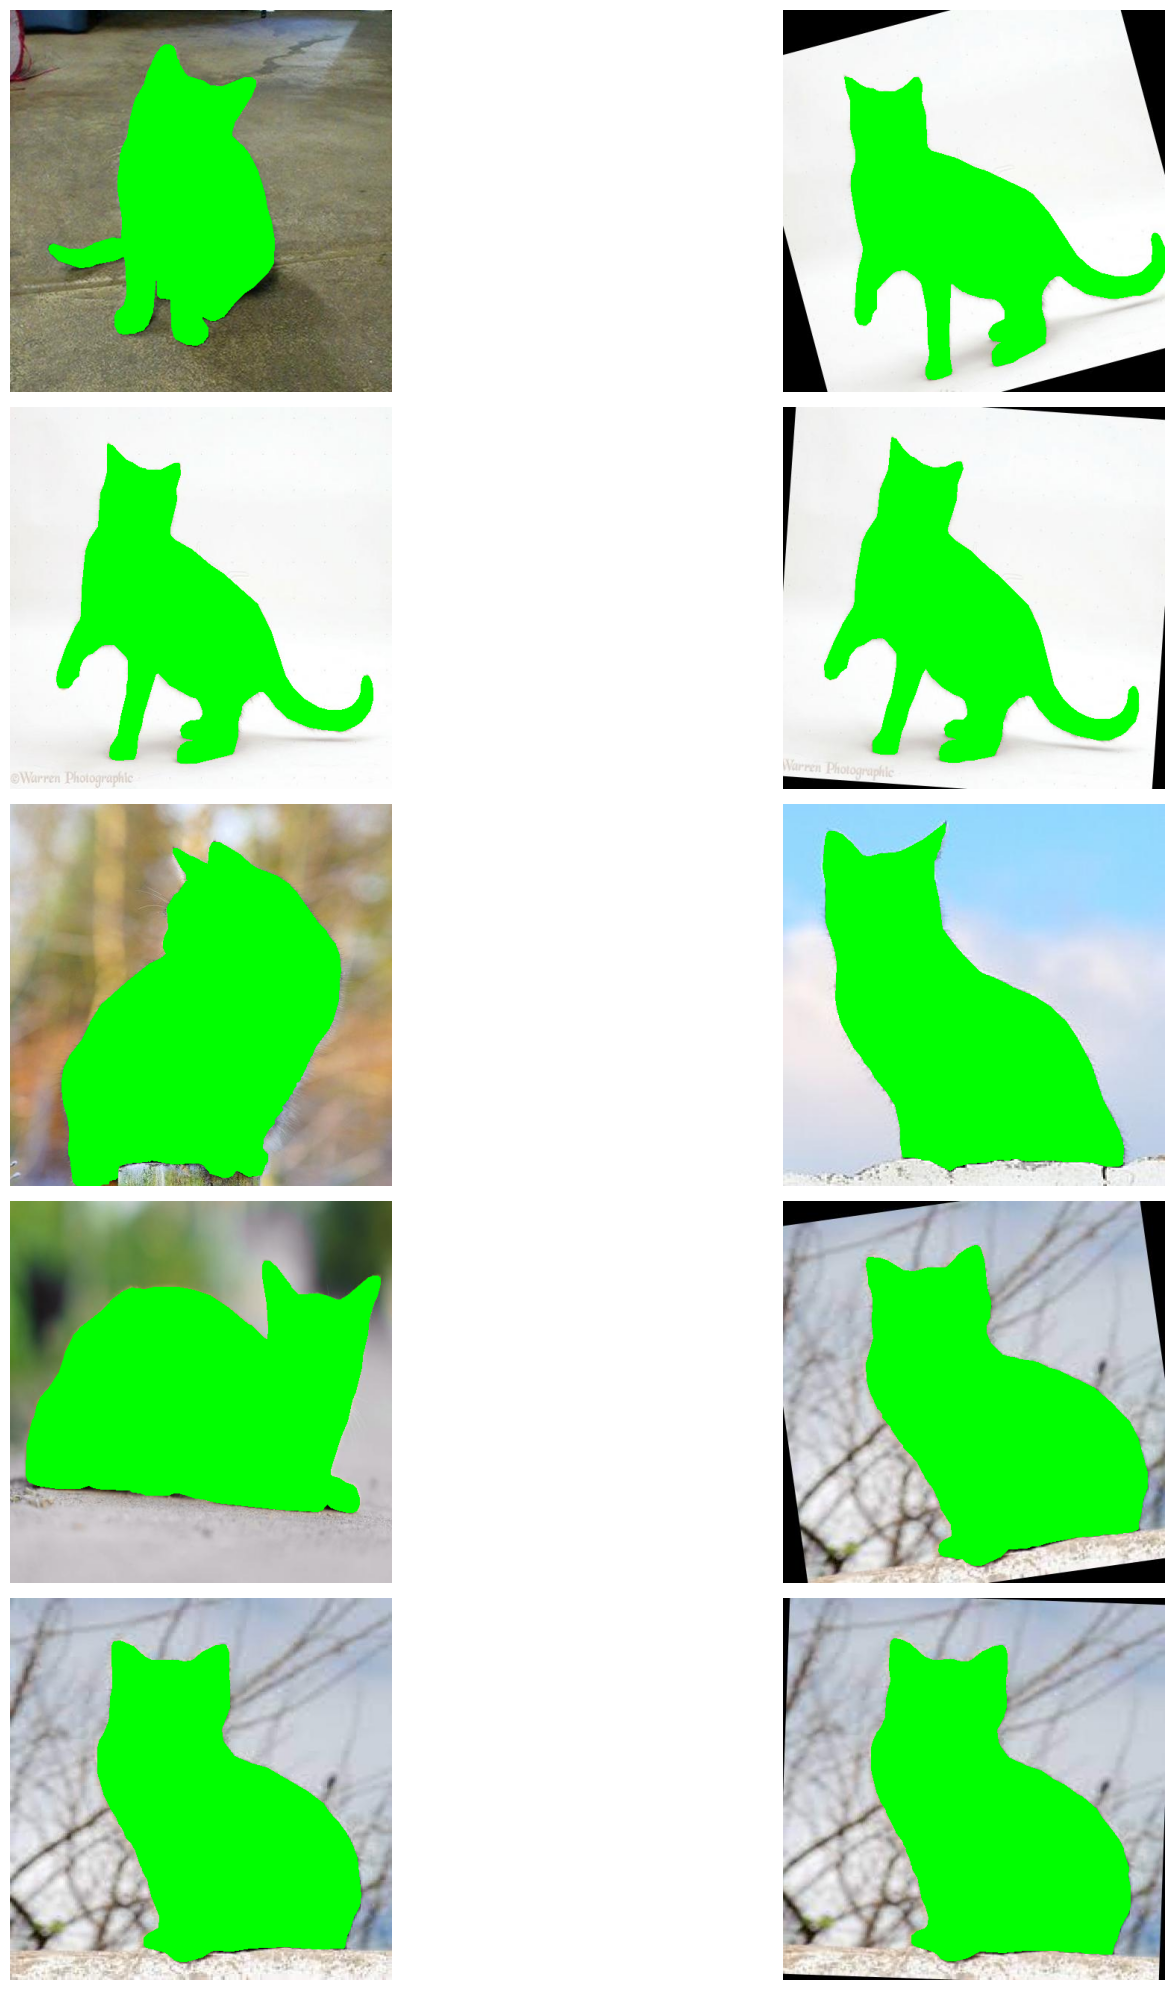

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import yaml
import os

def parse_yolo_segmentation(file_path):
    """
    Parse YOLO segmentation file and return a list of masks.
    """
    masks = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            points = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
            masks.append((class_id, points))
    return masks

def convert_normalized_coordinates(points, img_width, img_height):
    """
    Convert normalized coordinates to absolute pixel values.
    """
    points[:, 0] *= img_width
    points[:, 1] *= img_height
    return points.astype(np.int32)

def draw_masks_on_image(image, masks):
    """
    Draw segmentation masks on the image.
    """
    img_height, img_width = image.shape[:2]
    for class_id, points in masks:
        points = convert_normalized_coordinates(points, img_width, img_height)
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.fillPoly(image, [points], color=(0, 255, 0, 50))
    return image

# Define the path to the dataset and annotations
images_path = dataset_path + '/train/images'
annotations_path = dataset_path + '/train/labels'

# Get a list of image files and corresponding annotation files
image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.jpg')])
annotation_files = sorted([os.path.join(annotations_path, f) for f in os.listdir(annotations_path) if f.endswith('.txt')])

def visualize_images_with_masks(image_files, annotation_files, num_images=10):
    """
    Visualize a specified number of images with their segmentation masks.
    """
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        # Load image
        image = cv2.imread(image_files[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load and parse annotation
        masks = parse_yolo_segmentation(annotation_files[i])
        
        # Draw masks on image
        image_with_masks = draw_masks_on_image(image, masks)
        
        # Display the image with masks in a grid
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_with_masks)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize 10 images with their segmentation masks
visualize_images_with_masks(image_files, annotation_files, num_images=10)

In [6]:
import os

home_dir = os.environ.get("HOME")
print("HOME_DIR:", home_dir)

!rm -rf $home_dir/.config/Ultralytics


HOME_DIR: /home/pyrat


## Train the model

At the time of writing there are no pre-trained weights for YOLO12-Seg, so you need to train the model from scratch. Ideally we would pretrain on COCO dataset for at least 300 epochs before training on our own dataset. In this case we will train for 200 epochs on our own dataset.

In [7]:
from ultralytics import YOLO
 
model = YOLO('yolo12-seg.yaml')
yaml_path = dataset_path + "/data.yaml"
 
results = model.train(data=yaml_path, epochs=200)


WARNING ⚠️ no model scale passed. Assuming scale='n'.


Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
engine/trainer: task=segment, mode=train, model=yolo12-seg.yaml, data=/home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

100%|██████████| 755k/755k [00:00<00:00, 1.68MB/s]

Overriding model.yaml nc=80 with nc=3
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]    

  8                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 1]        
  9                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 10             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 11                  -1  1     86912  ultralytics.nn.modules.block.A2C2f           [384, 128, 1, False, -1]      
 12                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 13             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 14                  -1  1     24000  ultralytics.nn.modules.block.A2C2f           [256, 64, 1, False, -1]       
 15                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 16            [-1, 11]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/train/labels... 516 images, 0 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:00<00:00, 2835.12it/s]

train: New cache created: /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/train/labels.cache


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/valid/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 2789.58it/s]

val: New cache created: /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 122 weight(decay=0.0), 133 weight(decay=0.0005), 132 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.88G      3.023      7.735      4.185      4.227          7        640: 100%|██████████| 33/33 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        111        113    0.00277      0.758    0.00336    0.00145          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.81G       3.07      5.645      4.111      4.161          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all        111        113    0.00286      0.777    0.00491    0.00212    0.00143      0.407     0.0022   0.000523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.79G      3.097      5.045      4.091      4.086         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        111        113    0.00216      0.638    0.00276   0.000795    0.00181      0.519    0.00273   0.000626



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200       3.8G      3.018       4.78      4.037      3.931          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        111        113    0.00284      0.821     0.0124    0.00347    0.00102       0.31    0.00373   0.000625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.83G      3.025      4.487      3.935      3.711         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

                   all        111        113    0.00307      0.804     0.0297    0.00668   0.000834      0.217    0.00568   0.000809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.84G      2.842      4.366      3.872      3.496         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        111        113    0.00242      0.715     0.0184    0.00429    0.00123      0.363     0.0046   0.000947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200       3.8G      2.751      4.339      3.827        3.4          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        111        113      0.346    0.00952     0.0125    0.00279      0.337      0.019    0.00761    0.00176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200       3.8G       2.73      4.355      3.732      3.334         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        111        113     0.0031      0.869     0.0188     0.0039    0.00307      0.847     0.0206    0.00471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.83G      2.717      4.173      3.676      3.333         15        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        111        113    0.00889      0.619     0.0154    0.00328    0.00918      0.569     0.0199    0.00493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.79G      2.646      4.109      3.623      3.238         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113     0.0216      0.202     0.0195     0.0041     0.0152      0.131     0.0139    0.00341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.82G      2.584      4.111      3.607      3.203         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

                   all        111        113     0.0111      0.104     0.0228    0.00492      0.374     0.0286     0.0264    0.00823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200       3.8G      2.485       4.07      3.553      3.154         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

                   all        111        113     0.0147      0.128     0.0213    0.00433     0.0546     0.0646     0.0276    0.00819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.79G      2.452      3.969      3.489      3.114          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

                   all        111        113      0.074     0.0571      0.034    0.00841     0.0809     0.0571     0.0421     0.0145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200       3.8G      2.397      3.906      3.466      3.087         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

                   all        111        113     0.0115       0.13     0.0518     0.0114    0.00932      0.106     0.0518     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.82G      2.419      3.779      3.431      3.047          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

                   all        111        113     0.0365     0.0585     0.0406     0.0104     0.0436     0.0717     0.0533     0.0179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200       3.8G      2.347      3.758      3.386      3.019         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

                   all        111        113     0.0642     0.0741     0.0543     0.0134     0.0692       0.11     0.0557     0.0223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.81G      2.325      3.842      3.354      2.985         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

                   all        111        113     0.0458     0.0275     0.0633     0.0156     0.0512     0.0275      0.062     0.0224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200       3.8G      2.276      3.744      3.256      2.929         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

                   all        111        113     0.0758      0.332     0.0682      0.018     0.0769      0.334     0.0691     0.0249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.82G      2.236      3.723       3.23      2.926         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

                   all        111        113     0.0993      0.302     0.0772      0.019      0.149       0.22      0.076     0.0252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.78G      2.234      3.641      3.259      2.903          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

                   all        111        113     0.0725      0.393     0.0592     0.0171     0.0739      0.402     0.0639      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.79G      2.173      3.585      3.145      2.834          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

                   all        111        113     0.0599     0.0628     0.0358     0.0117     0.0623     0.0628     0.0302     0.0117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200       3.8G      2.166      3.596      3.075      2.848         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

                   all        111        113      0.121      0.288      0.108     0.0362      0.124      0.255     0.0984     0.0438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.78G      2.147      3.495      3.059       2.84         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]

                   all        111        113     0.0785      0.296     0.0655     0.0208     0.0629      0.211     0.0664     0.0234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.82G      2.133      3.486       3.06      2.797          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

                   all        111        113     0.0932      0.253     0.0728     0.0242      0.098      0.176     0.0672     0.0277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.77G      2.095      3.465      3.014      2.777          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all        111        113      0.134      0.203      0.102     0.0349      0.168      0.186     0.0912      0.041



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200       3.8G      2.084      3.413      2.999      2.787          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

                   all        111        113     0.0985      0.193     0.0882     0.0325      0.103        0.2      0.085     0.0381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.82G      2.054      3.393      2.941      2.723         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

                   all        111        113      0.219      0.411      0.156     0.0599      0.245      0.436      0.163     0.0736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200       3.8G      2.028      3.373      2.903      2.695         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

                   all        111        113      0.177      0.309      0.166     0.0711      0.178      0.302      0.166     0.0799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.79G       1.99      3.351       2.84      2.675          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all        111        113       0.12      0.402      0.163     0.0522      0.175      0.355      0.165     0.0639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.79G       1.96      3.259      2.817      2.636         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

                   all        111        113      0.171      0.429      0.178     0.0689      0.189      0.428      0.169     0.0784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200       3.8G      1.985      3.311      2.791      2.627         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.52it/s]

                   all        111        113      0.157      0.293      0.146     0.0595      0.156      0.292      0.152     0.0698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.82G      1.903      3.166      2.769      2.573         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        111        113      0.184      0.389      0.174     0.0685      0.202      0.429      0.165     0.0766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.81G      1.909      3.182      2.694      2.578         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

                   all        111        113      0.196      0.331      0.186     0.0857       0.19      0.306      0.188     0.0841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.79G      1.903      3.148      2.707      2.567         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]

                   all        111        113      0.184      0.359      0.181     0.0757      0.186      0.362      0.179     0.0822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.79G      1.865      3.132      2.638      2.494         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

                   all        111        113      0.253      0.432      0.242      0.105       0.25      0.416      0.238      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.82G      1.886      3.174      2.654      2.519         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all        111        113      0.194      0.437      0.191     0.0897      0.193      0.437      0.195     0.0954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.79G      1.851      3.086      2.592      2.481          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        111        113      0.208      0.392      0.184     0.0787      0.202      0.374      0.176     0.0864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.81G      1.798      3.182      2.565      2.451          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        111        113       0.22      0.449       0.25      0.106      0.226      0.423      0.227     0.0998



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.78G       1.78      3.033      2.591      2.429          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        111        113      0.196      0.362      0.201     0.0873      0.214      0.379      0.198     0.0976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200       3.8G      1.772      3.097       2.54      2.423          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

                   all        111        113      0.253      0.452      0.253      0.125      0.231      0.454      0.241       0.13



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.79G      1.733      3.057      2.561      2.381          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113      0.254      0.459      0.267      0.125      0.236      0.417      0.238      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.79G      1.772      2.956      2.513      2.421         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]

                   all        111        113      0.183      0.464      0.215     0.0943      0.188      0.477      0.221      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200       3.8G      1.754      2.957      2.517      2.388         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        111        113      0.195      0.277      0.146     0.0697      0.181      0.227      0.141       0.08



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.84G      1.729      2.883      2.438      2.351         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        111        113      0.207      0.357      0.194     0.0914      0.211      0.358      0.204      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.81G       1.71      2.872      2.436      2.323          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

                   all        111        113      0.257      0.432      0.244      0.131      0.263      0.426      0.244      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.79G      1.698      2.849      2.409      2.316          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        111        113      0.254      0.557      0.281      0.139      0.263      0.574      0.275      0.154



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.83G       1.74      2.827      2.424      2.332          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

                   all        111        113      0.242      0.719      0.275      0.141      0.245      0.701      0.286      0.143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.77G      1.654       2.76      2.329      2.258          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]

                   all        111        113      0.248      0.519      0.282      0.133      0.254      0.532      0.281      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.79G      1.636      2.785      2.351      2.252          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        111        113      0.226       0.51      0.284      0.155      0.255       0.51      0.286      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200       3.8G       1.62      2.818      2.321      2.224          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        111        113      0.222      0.579      0.255      0.131      0.214      0.542      0.262      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.78G      1.577      2.687      2.247      2.186          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        111        113      0.255      0.524      0.327      0.185      0.262       0.53      0.337      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.79G      1.602      2.739      2.267      2.204         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113       0.21      0.693      0.336      0.165      0.245      0.716      0.349      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200       3.8G      1.576      2.686       2.18      2.197         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113       0.22      0.572      0.308      0.167      0.228      0.572      0.313      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200       3.8G      1.526      2.662      2.204      2.135         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        111        113      0.269      0.598      0.351      0.196      0.277      0.589      0.341      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.81G      1.582      2.756      2.219      2.207         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        111        113      0.316       0.53      0.312      0.171      0.309      0.503      0.295      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.79G      1.556      2.691       2.19      2.145         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        111        113      0.277      0.467      0.292      0.163      0.286      0.516      0.293      0.181



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.77G      1.499      2.612      2.142      2.092         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113      0.275      0.617        0.3      0.162      0.321      0.635      0.309      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.79G      1.536      2.614      2.167      2.129         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        111        113      0.301      0.634        0.4      0.211      0.308      0.641      0.404      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.82G      1.508      2.491       2.09      2.088         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all        111        113      0.302      0.554      0.328      0.178      0.302       0.62      0.332      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.79G      1.472      2.467      2.041      2.065          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.359      0.625      0.422      0.252       0.42      0.588      0.426       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.79G      1.457      2.456      2.052      2.046         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.411       0.53      0.447       0.26       0.43       0.54      0.449      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.79G      1.501      2.594      2.116      2.087         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        111        113      0.347      0.625      0.389      0.225      0.347      0.615      0.392      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.81G      1.492      2.467      2.026      2.062         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        111        113      0.337      0.693      0.432      0.238      0.346      0.667       0.42      0.258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.81G       1.46      2.444      2.019      2.061         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all        111        113      0.301      0.627      0.371      0.217      0.304      0.637      0.373      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.79G      1.467      2.414      2.015      2.057          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        111        113       0.37      0.622      0.435      0.237      0.372      0.622      0.434      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.77G      1.429      2.433      1.968      2.004         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.322       0.71      0.419      0.231      0.327      0.685      0.418       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.79G      1.484      2.517      2.055      2.071          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.343      0.639      0.392       0.23      0.342       0.64       0.38       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.79G      1.422      2.382      1.966      2.029         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.367      0.566      0.425      0.242      0.392      0.584      0.445      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.79G      1.436      2.332      2.002      2.002          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113      0.315      0.741      0.425       0.25      0.313      0.744      0.417      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.81G      1.399      2.378      1.986      1.999         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        111        113      0.361      0.683      0.432       0.26      0.359      0.685      0.431       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200       3.8G      1.357      2.265      1.923       1.96          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all        111        113      0.331      0.732       0.45      0.262      0.337      0.723      0.446      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.79G      1.357      2.319      1.902      1.936          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.283      0.509      0.329      0.204      0.266      0.499      0.321      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.78G      1.348      2.317      1.929      1.946          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.402      0.757      0.478      0.293      0.397      0.717      0.473      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.77G      1.372      2.337      1.932      1.941         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.328      0.619       0.41      0.246      0.348      0.617      0.406      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.79G      1.351      2.233      1.868       1.92         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.428       0.63      0.479      0.284      0.432       0.63      0.474      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.81G      1.355      2.308      1.935      1.948         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all        111        113      0.315      0.571      0.424      0.267      0.341      0.598       0.44      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.79G      1.374      2.276       1.94      1.967         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.372      0.711      0.447      0.261       0.37      0.693      0.458      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.79G        1.4      2.226      1.904      1.977         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        111        113      0.367      0.625      0.471       0.25      0.369      0.625      0.472       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.79G      1.351      2.268      1.873      1.935         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.375      0.668      0.473      0.293      0.365      0.651      0.462       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.81G      1.332      2.215      1.836      1.902         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.364      0.749      0.444      0.282      0.368      0.763      0.444      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.79G      1.321      2.212      1.866       1.89          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.328      0.778      0.434      0.271      0.346      0.774      0.442      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.78G      1.332      2.162      1.875      1.895         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        111        113      0.467      0.628      0.492      0.318       0.47       0.62      0.486      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.81G      1.267      2.208      1.788       1.87         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        111        113      0.336      0.772      0.381      0.243      0.341      0.799      0.397      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.81G      1.245      2.185       1.79      1.842          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all        111        113      0.388      0.758      0.501       0.32      0.398      0.732      0.503      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.78G      1.293      2.182      1.819      1.867         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.394      0.626       0.52       0.33       0.39       0.61       0.51      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.83G      1.268      2.145      1.779       1.85         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.354      0.707      0.443      0.271      0.346      0.699      0.444      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.81G      1.265      2.036      1.776      1.837         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113       0.41      0.784      0.466        0.3      0.409      0.769      0.457       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.79G      1.245      2.043      1.752      1.808         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113       0.38      0.646      0.479      0.311        0.4      0.604      0.502      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.78G      1.245      2.071      1.712      1.815         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.387      0.802      0.494      0.322      0.424      0.798      0.513      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.79G      1.208      2.041      1.752      1.796         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.434      0.613      0.513      0.328      0.457       0.62      0.527      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.77G      1.269      2.122      1.784      1.853         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.403      0.727      0.498       0.33      0.403      0.727      0.498      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.79G      1.209      2.076       1.71      1.793          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all        111        113      0.474      0.548      0.505      0.312      0.483      0.557      0.513      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200       3.8G      1.246      2.097       1.76      1.823         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.364      0.703      0.532      0.347      0.369      0.705      0.537      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.81G      1.225      2.169      1.735      1.826          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        111        113      0.441       0.75      0.579      0.366      0.435      0.742      0.569      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200       3.8G      1.224      2.014      1.721      1.803          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all        111        113      0.431      0.574      0.463      0.304      0.465       0.59      0.466      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.81G       1.24      1.975      1.719      1.812          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.483      0.636      0.579      0.378      0.475      0.647      0.586       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200       3.8G      1.222      1.948      1.667      1.787         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.447      0.587      0.537      0.375      0.452       0.59      0.532      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.84G      1.237      2.089      1.682      1.806          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

                   all        111        113       0.46      0.649      0.518      0.337      0.453      0.645      0.505      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.82G      1.145      2.063      1.657      1.747         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113      0.491      0.687      0.586      0.365      0.467      0.662      0.568      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.79G      1.179      1.992      1.668      1.758         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.475      0.771       0.61      0.398       0.48       0.75      0.602      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200       3.8G      1.176      1.982       1.64      1.765         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        111        113      0.473      0.612      0.529      0.348      0.485       0.63       0.54      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.81G      1.196       2.03      1.677      1.766         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.382      0.798      0.544      0.367      0.401      0.767      0.558      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.79G      1.129      1.903      1.625      1.714          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.496      0.778      0.587        0.4      0.488      0.775      0.585      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.79G      1.165      1.917      1.584      1.741         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113      0.427      0.703       0.57       0.39      0.423      0.701      0.562      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.77G      1.139      1.886      1.622      1.707         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113       0.53      0.676      0.598        0.4      0.527       0.69      0.618      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.79G      1.165      1.907      1.619       1.75         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        111        113      0.529      0.707      0.604      0.414      0.502      0.758      0.613      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.78G      1.167      1.875      1.627      1.713          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        111        113      0.512      0.772      0.633      0.448      0.505      0.747      0.629      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.78G      1.154      1.893      1.613      1.717         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.516      0.724      0.637      0.442      0.497      0.724       0.63      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200       3.8G      1.155      1.901      1.603      1.715         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113      0.593      0.734      0.655      0.466      0.578      0.751      0.644      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.79G      1.137      1.941      1.617      1.704          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        111        113      0.526      0.593      0.616      0.418      0.536      0.594      0.611      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.77G      1.123        1.9      1.616      1.695         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.578      0.737      0.635      0.445      0.567      0.731      0.626      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.79G      1.108      1.876      1.594      1.673         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        111        113      0.539      0.783      0.656      0.475      0.543      0.793       0.66      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200       3.8G      1.119      1.921      1.565      1.693          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.549      0.619      0.594      0.413      0.551      0.627      0.604      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.79G      1.149      1.877       1.58      1.725          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all        111        113      0.689      0.645      0.678      0.486      0.684      0.636       0.68      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.81G      1.106      1.858      1.557      1.675          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113      0.543      0.685       0.67      0.454      0.552      0.691      0.681      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.79G      1.135      1.836      1.593      1.706         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all        111        113      0.532      0.665      0.627      0.439      0.546      0.676      0.646      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200       3.8G      1.135      1.807      1.608      1.686         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.439      0.836      0.616       0.44      0.433      0.828      0.608      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.79G      1.122      1.855      1.605      1.707         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all        111        113      0.602      0.705      0.664       0.47      0.615      0.716      0.672      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.79G      1.086      1.873      1.542      1.659         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        111        113      0.585      0.766       0.69      0.515      0.594      0.774        0.7      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.81G      1.087      1.822      1.535      1.667          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.579      0.747      0.726      0.506      0.563      0.734      0.707      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.79G       1.08      1.781        1.5      1.663          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all        111        113      0.561      0.735      0.694       0.47      0.552      0.736      0.679      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.79G      1.104      1.789      1.534      1.664          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all        111        113      0.605      0.712      0.684      0.474      0.609       0.72      0.688      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.78G      1.049      1.805      1.547      1.628          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        111        113      0.627      0.725      0.742      0.544      0.627      0.734      0.735       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.79G      1.049      1.775      1.503      1.618         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.599      0.793      0.734      0.533      0.596      0.804      0.734      0.562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.78G      1.058      1.809      1.489       1.62         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.501      0.738      0.674      0.493      0.517      0.739       0.69      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.81G      1.072      1.794      1.531      1.632          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        111        113      0.484      0.753      0.591      0.401      0.496      0.769      0.635      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.81G      1.034      1.743       1.49      1.606          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.603      0.729      0.737      0.537      0.603      0.729      0.728      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.77G      1.039      1.706      1.481      1.593          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all        111        113      0.697      0.736      0.752      0.532      0.715      0.753      0.768      0.586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.78G      1.063      1.753      1.486      1.618         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all        111        113      0.559      0.747      0.703      0.493      0.526      0.819      0.718      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.79G       1.07      1.752      1.477      1.629         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        111        113      0.569      0.847      0.715      0.492      0.568      0.853       0.72      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.78G      1.028      1.727      1.467       1.59          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all        111        113       0.59      0.764      0.692      0.496      0.551      0.754      0.681      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.79G      1.006      1.726      1.442      1.577         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all        111        113      0.555      0.683      0.654      0.457      0.568      0.718       0.68      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.79G      1.064      1.849      1.493      1.638          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.557      0.679      0.641      0.471      0.566      0.688      0.657      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.79G      1.001      1.667      1.394      1.563         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.595      0.781      0.689      0.486      0.599      0.789      0.709      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.82G      1.011      1.652      1.389      1.574          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113      0.616      0.747      0.721      0.532      0.633       0.73      0.728      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.79G       1.01      1.668      1.391      1.568         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

                   all        111        113      0.638      0.791      0.734      0.532      0.642      0.803      0.746      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.77G     0.9726      1.643      1.381      1.564          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all        111        113      0.589      0.836      0.733      0.523      0.595      0.845      0.745      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.79G       1.03      1.696      1.382      1.584         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.608      0.846      0.759      0.545      0.634      0.836      0.783      0.599



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.79G      1.015      1.649      1.372      1.566          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all        111        113       0.61        0.8      0.728      0.517      0.616      0.774      0.739      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200       3.8G      1.005      1.741      1.413      1.577          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all        111        113      0.699      0.657      0.707       0.53      0.695      0.649      0.691      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200       3.8G     0.9864      1.627      1.409      1.555         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        111        113      0.654      0.711      0.731      0.544      0.716      0.678      0.762      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.81G      1.003      1.649        1.4      1.553          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all        111        113      0.669      0.691       0.74      0.517      0.675      0.705      0.751       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.81G      1.009      1.658      1.393      1.573         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.601      0.751      0.706      0.504      0.616      0.766      0.724      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.81G     0.9689      1.622       1.36      1.536         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all        111        113      0.655      0.769      0.763      0.559      0.668      0.777      0.775      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.77G      1.018      1.588      1.379       1.58         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.636      0.746      0.729      0.539       0.64      0.754      0.739      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.81G     0.9712      1.617      1.348      1.519         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.618      0.782      0.798      0.568      0.748      0.656      0.812       0.62



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.79G      1.004      1.682      1.385      1.566         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all        111        113       0.69      0.791      0.785      0.591       0.69      0.791      0.785      0.634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200       3.8G      0.996      1.667       1.35      1.564          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        111        113      0.673      0.791      0.791      0.577      0.683      0.747      0.791      0.619



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200       3.8G     0.9994      1.707      1.379      1.549         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.713      0.767      0.803      0.578      0.713      0.767      0.803      0.627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.79G     0.9715      1.636      1.359      1.552          6        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        111        113      0.657       0.82      0.822      0.604      0.664       0.83      0.832      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      3.79G     0.9341      1.597      1.312      1.512         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.713      0.776      0.834      0.629      0.692      0.786      0.832      0.642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.79G     0.9361      1.559      1.292       1.51          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        111        113      0.736      0.753      0.846      0.641       0.73      0.744      0.842      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.78G     0.9448       1.56      1.325      1.521         18        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113       0.78      0.807       0.86       0.64      0.779      0.797       0.85      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.81G     0.9644       1.65      1.344      1.521          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        111        113      0.734      0.742      0.822       0.61      0.742      0.751       0.83      0.644



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.81G     0.9907      1.646      1.367      1.563          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all        111        113       0.79      0.791      0.854      0.656       0.79      0.791      0.854      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.79G     0.9143      1.591       1.26      1.484          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

                   all        111        113       0.77      0.833      0.858       0.63      0.778      0.841      0.866      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.81G     0.9812      1.707       1.35      1.543          5        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.711      0.775      0.799      0.599      0.756      0.742      0.815      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200       3.8G      0.969      1.596      1.304      1.535          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        111        113      0.829      0.812      0.873      0.669      0.787      0.819      0.879      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.81G     0.9351      1.576      1.272      1.504         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.743      0.824      0.833      0.631      0.771      0.848      0.867      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.81G     0.9261      1.519      1.261      1.489         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.724      0.799      0.837      0.642      0.724      0.799      0.837      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200       3.8G     0.9414      1.648      1.311      1.511          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.727       0.79      0.856      0.657      0.727       0.79      0.856        0.7



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.85G     0.9197       1.51      1.303      1.496         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.691      0.837      0.842      0.637      0.691      0.837      0.842      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.79G     0.9277      1.541      1.258      1.504          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.692      0.832      0.844      0.644      0.692      0.832      0.844      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.81G     0.9349      1.602      1.308      1.498         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.617      0.849      0.807      0.653      0.639      0.871      0.843       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200       3.8G     0.8876      1.529      1.247      1.454         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        111        113      0.675      0.871      0.843      0.651      0.682      0.879      0.856       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.79G     0.9366      1.563      1.289        1.5         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

                   all        111        113      0.835      0.848      0.909      0.695      0.835      0.848      0.909      0.729



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200       3.8G     0.9238      1.579      1.241       1.49          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.772      0.785       0.85      0.629      0.781      0.793      0.858      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.81G     0.9373       1.51      1.259      1.511         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

                   all        111        113      0.787      0.786      0.838      0.642      0.792      0.784      0.833      0.682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.78G     0.9474      1.602       1.29      1.495          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.684      0.877      0.872      0.669       0.69      0.884      0.878      0.705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.79G     0.9148      1.524      1.245      1.483          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        111        113      0.765      0.743      0.838      0.655      0.786       0.76      0.856      0.685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.79G     0.8809      1.535      1.233      1.455         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.807      0.791      0.893      0.695      0.807      0.791      0.898      0.725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.79G     0.8894      1.434      1.214      1.461         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

                   all        111        113      0.836      0.737       0.88      0.696      0.836      0.737      0.883       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200       3.8G     0.9191      1.563      1.242      1.478         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

                   all        111        113      0.732      0.796      0.872      0.673      0.727      0.788      0.864      0.704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.79G     0.9002       1.52      1.212       1.47          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

                   all        111        113      0.836      0.799        0.9      0.711      0.836      0.799        0.9      0.725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.77G     0.9086      1.534      1.246      1.488         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all        111        113      0.847      0.806      0.915      0.705       0.85      0.786      0.906      0.733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.79G     0.9424      1.569       1.25      1.505          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all        111        113      0.802      0.704      0.846      0.663      0.802      0.704      0.846       0.69



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.78G     0.8782      1.436      1.179      1.452         12        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all        111        113      0.807      0.836      0.909      0.704      0.807      0.836      0.903      0.719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.79G     0.8987      1.467      1.211      1.469         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.789      0.832      0.889      0.672      0.794      0.833      0.895      0.705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.81G     0.8908      1.442      1.208      1.459          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all        111        113       0.78      0.885      0.907      0.711      0.775      0.858        0.9      0.729



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.81G     0.8524      1.478      1.239      1.454         14        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.833      0.808      0.893      0.698      0.833      0.808      0.893      0.726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.79G     0.8756      1.559      1.218      1.457         11        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.753      0.896      0.903      0.698      0.753      0.896      0.902      0.731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.81G     0.8846      1.535      1.212      1.473          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.781       0.83      0.878      0.684      0.792      0.838      0.883       0.71



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.81G     0.8763      1.452      1.177      1.442         13        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all        111        113      0.816      0.806      0.898      0.717      0.816      0.806      0.891      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.81G     0.8567      1.498      1.193      1.438          8        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all        111        113      0.743      0.792      0.877      0.693      0.743      0.792      0.881      0.708



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200       3.8G     0.8689      1.485      1.184      1.455          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        111        113      0.791      0.873      0.905       0.72      0.791      0.873      0.898      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.78G     0.8499      1.449      1.166      1.431          7        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        111        113      0.781      0.904      0.924       0.74      0.774      0.896      0.916      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.77G     0.8593      1.486      1.184      1.442          9        640: 100%|██████████| 33/33 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.767      0.848      0.913      0.719      0.761      0.839      0.905      0.749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.77G     0.8601      1.588      1.213      1.447         10        640: 100%|██████████| 33/33 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all        111        113      0.911      0.816      0.929      0.735      0.927      0.802       0.92      0.755



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200       3.8G     0.8475      1.489        1.2      1.428         18        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        111        113      0.823      0.878      0.931      0.739      0.823      0.878      0.924      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.79G      0.842      1.472      1.157      1.425         16        640: 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.871      0.845      0.924      0.729      0.881      0.854      0.927      0.755


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.82G     0.7074      1.225      1.037       1.37          4        640: 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.824      0.819      0.924      0.729      0.828      0.817      0.917      0.759



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.74G     0.7008      1.217     0.9097      1.382          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all        111        113      0.786      0.848      0.921      0.733      0.786      0.848      0.915      0.757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.73G      0.718      1.236     0.8899        1.4          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

                   all        111        113      0.857      0.826      0.936      0.761      0.857      0.826      0.929      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.74G     0.6769      1.219      0.821      1.361          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        111        113      0.895       0.81      0.937      0.749      0.895       0.81      0.932      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.74G     0.6565      1.179      0.794       1.32          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        111        113      0.874      0.864      0.929      0.736      0.879      0.851      0.923      0.757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.74G     0.6863      1.149     0.8586      1.366          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

                   all        111        113      0.859      0.804      0.935      0.757      0.867      0.812      0.936      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.73G     0.6543      1.136     0.7929      1.337          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all        111        113      0.845      0.791      0.928      0.755      0.855      0.799      0.931      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.74G     0.6718      1.213     0.8061      1.359          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        111        113      0.888      0.782      0.925       0.73      0.868      0.799      0.927      0.763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.74G     0.6496      1.116      0.786      1.328          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all        111        113       0.87      0.841      0.933      0.746      0.874       0.85      0.932      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.74G     0.6506      1.191     0.8203      1.334          4        640: 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

                   all        111        113      0.873      0.817      0.942      0.762      0.892      0.823      0.942      0.789



200 epochs completed in 0.348 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO12-seg summary (fused): 172 layers, 2,809,729 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


                   all        111        113      0.837      0.864      0.942      0.762      0.893      0.823      0.943      0.789
                   cat         40         41      0.775      0.854      0.916      0.705      0.827      0.829      0.916      0.746
                   dog         36         37      0.916       0.88      0.972      0.781      0.967      0.811      0.972      0.817
                   fox         35         35      0.819      0.857      0.939      0.802      0.883      0.829      0.939      0.805
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train


## Visualize training results

In [8]:
!ls {HOME}/runs/segment/train/

BoxF1_curve.png       confusion_matrix_normalized.png  train_batch6272.jpg
BoxPR_curve.png       labels.jpg		       val_batch0_labels.jpg
BoxP_curve.png	      labels_correlogram.jpg	       val_batch0_pred.jpg
BoxR_curve.png	      results.csv		       val_batch1_labels.jpg
MaskF1_curve.png      results.png		       val_batch1_pred.jpg
MaskPR_curve.png      train_batch0.jpg		       val_batch2_labels.jpg
MaskP_curve.png       train_batch1.jpg		       val_batch2_pred.jpg
MaskR_curve.png       train_batch2.jpg		       weights
args.yaml	      train_batch6270.jpg
confusion_matrix.png  train_batch6271.jpg


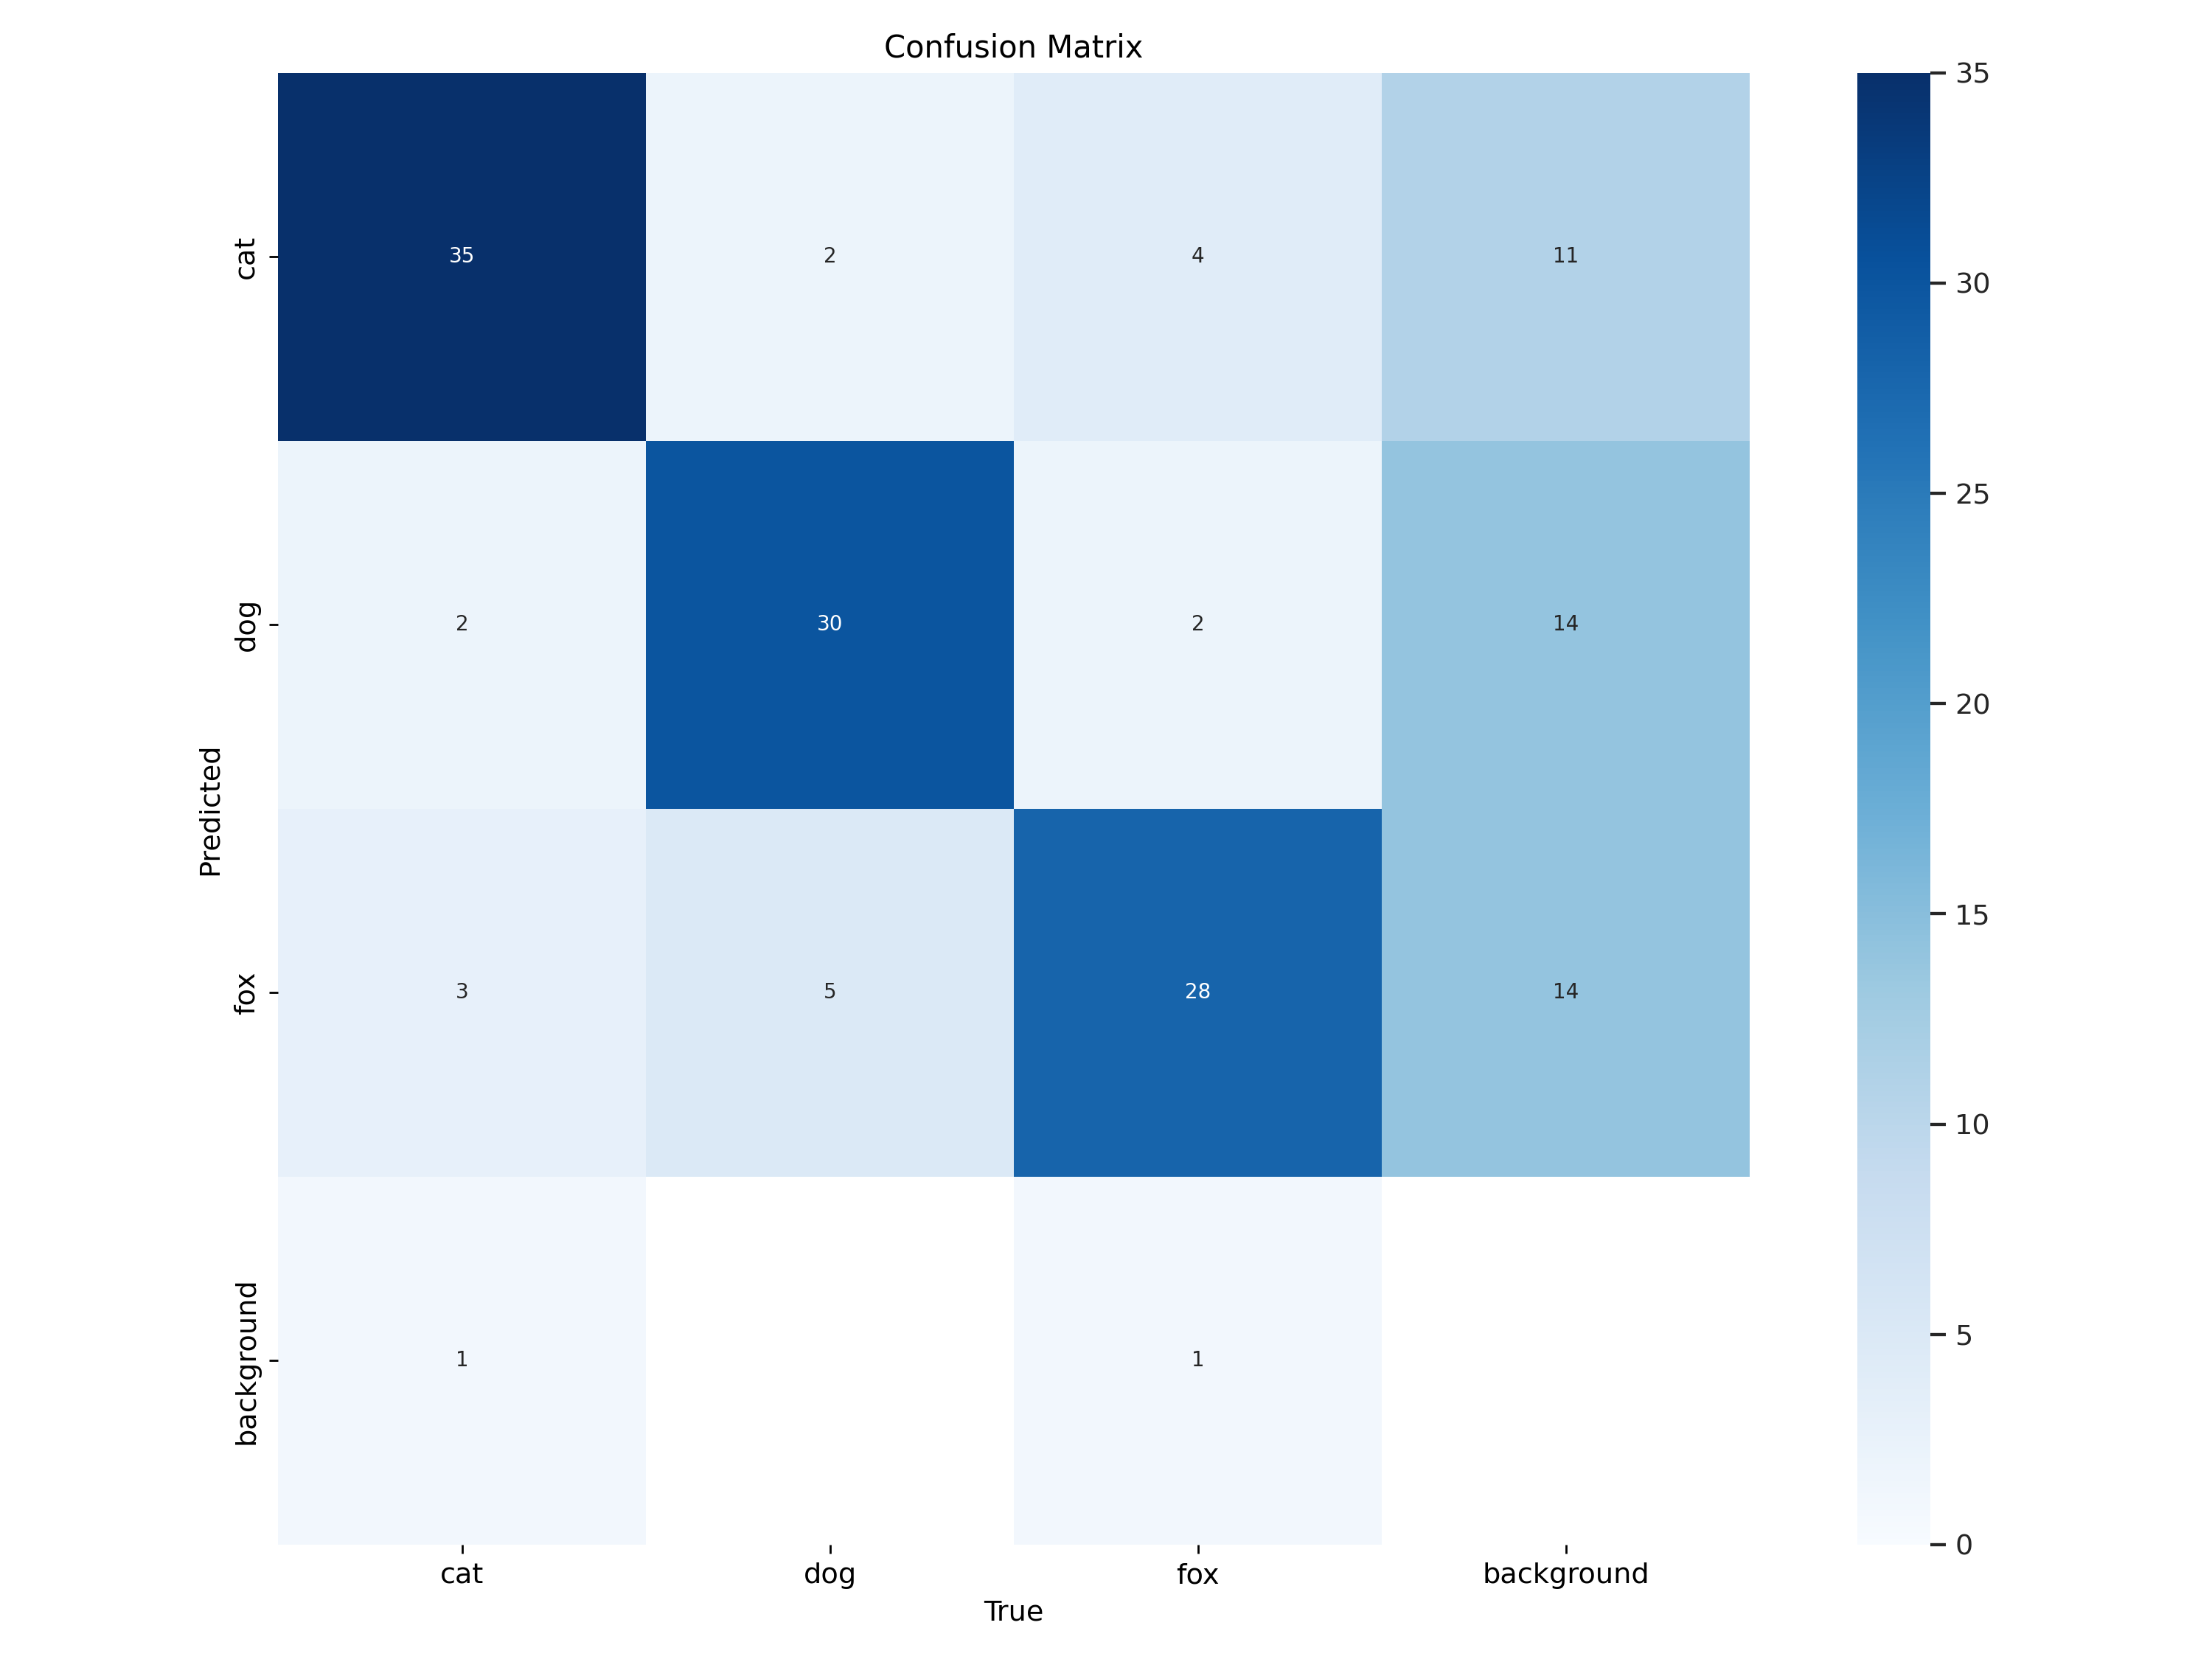

In [9]:
from IPython.display import display, Image
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

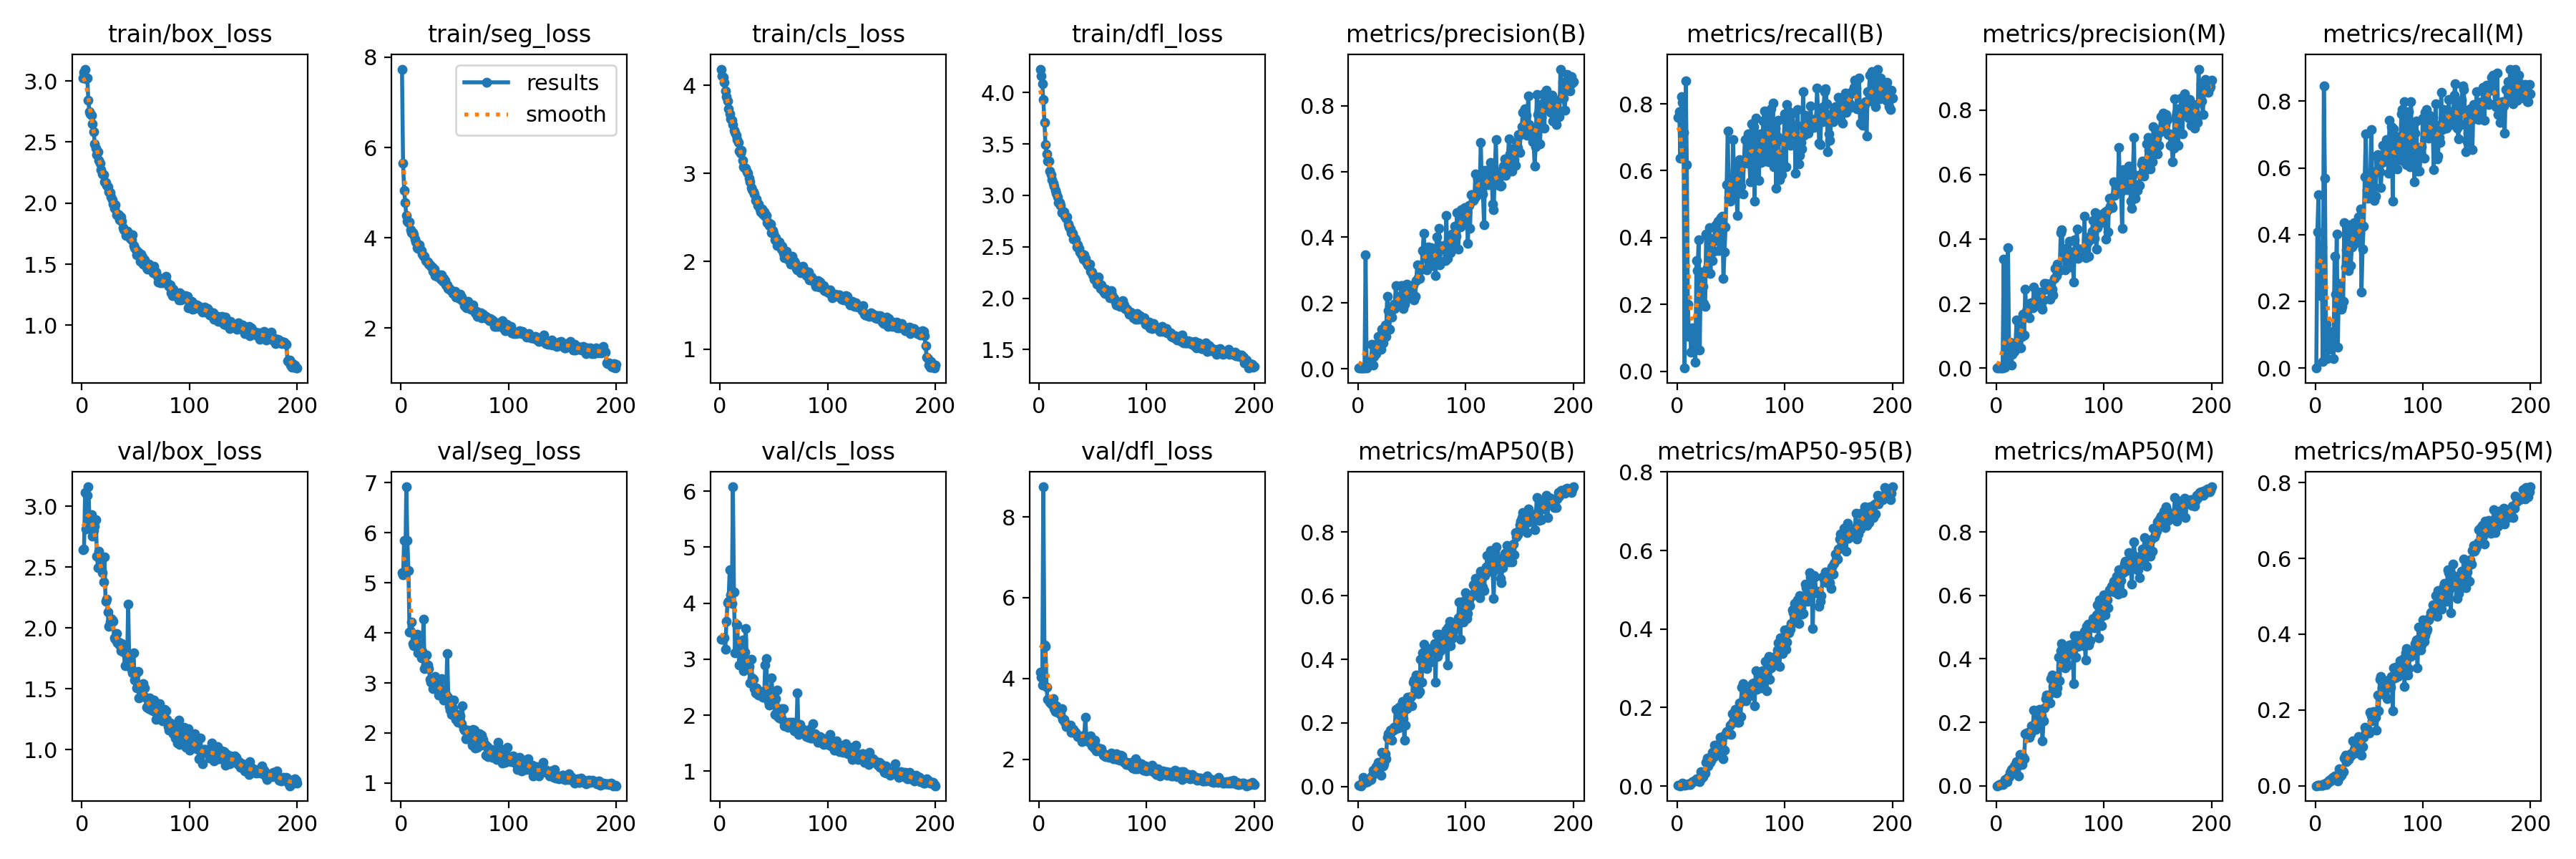

In [10]:
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

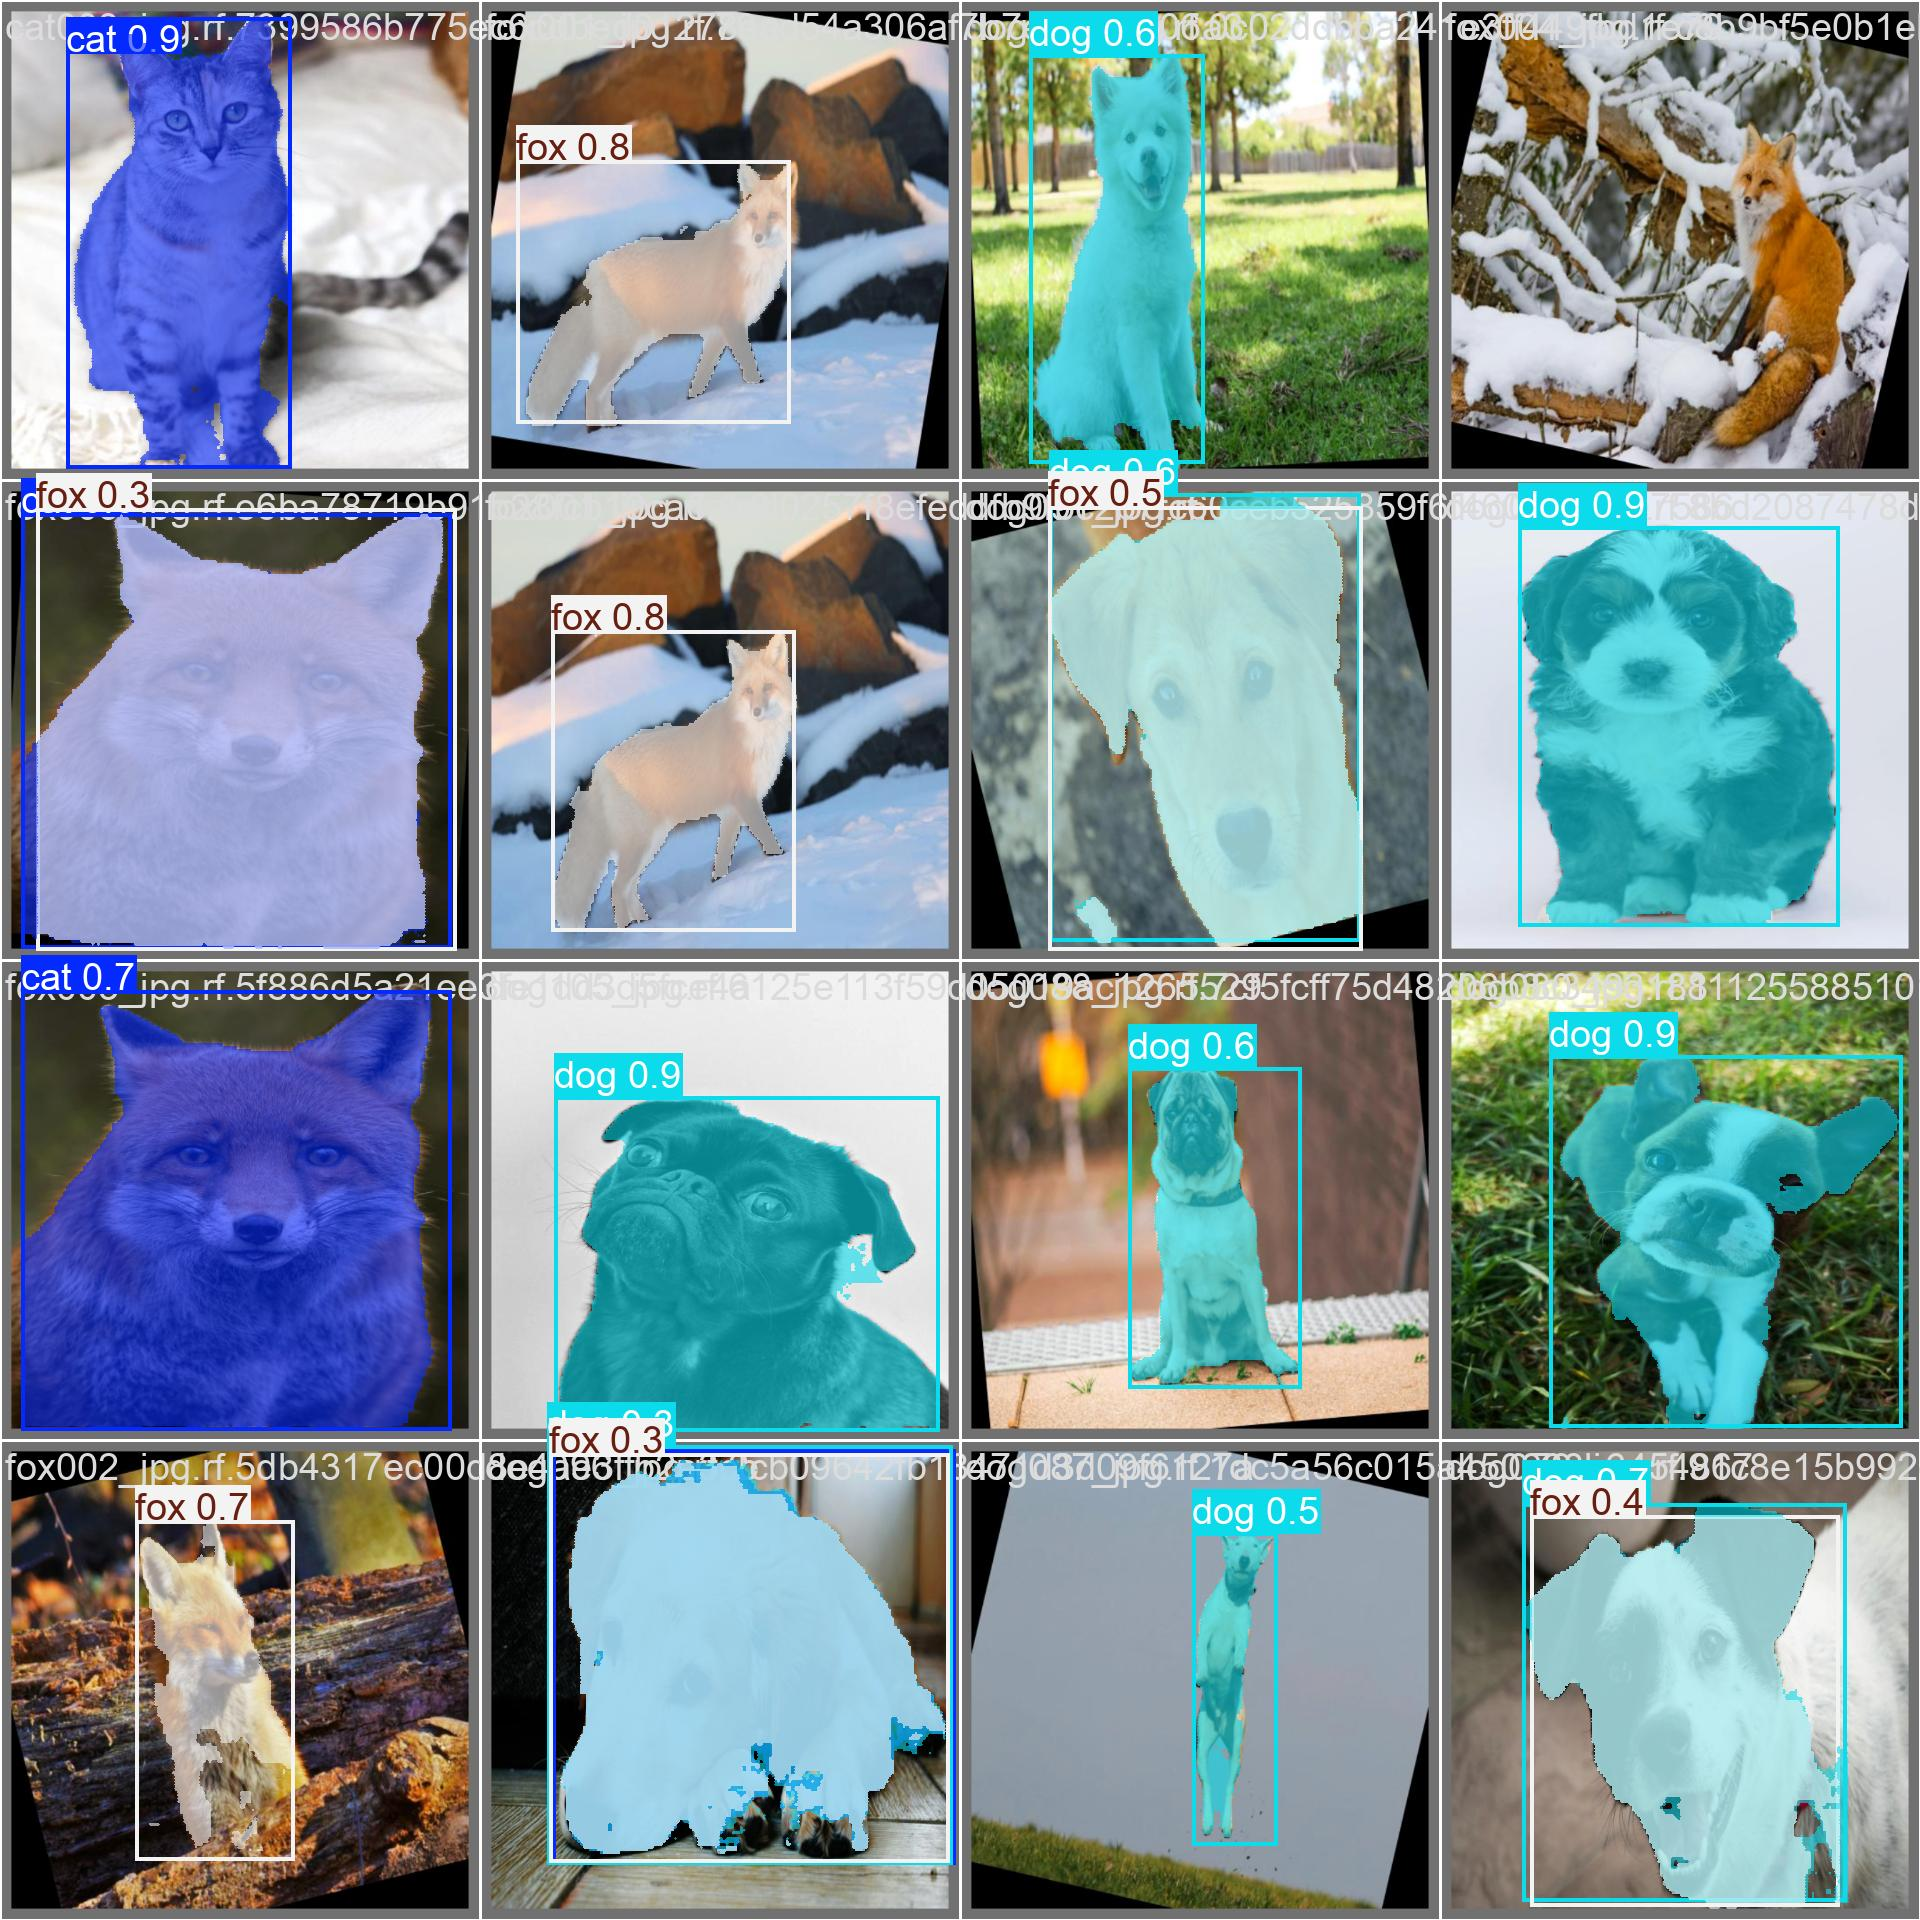

In [11]:
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

# Validate the Model

You can use the YOLO CLI to validate the model on a validation set. This will give you the mAP score for the model.

In [12]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data=$yaml_path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/pyrat/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO12-seg summary (fused): 172 layers, 2,809,729 parameters, 0 gradients, 10.2 GFLOPs
val: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        111        113      0.837      0.864      0.942      0.764      0.892      0.823      0.942      0.788
                   cat         40         41      0.776      0.854      0.915      0.707      0.826      0.829      0.916      0.745
                   dog         36         37      0.916       0.88  

## Inference on the Test Set

You can use the YOLO CLI to run inference on the test set. This will give you the predictions for the test set and we can visualize them here.

In [13]:
!yolo predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source=$dataset_path/test/images save=True

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO12-seg summary (fused): 172 layers, 2,809,729 parameters, 0 gradients, 10.2 GFLOPs

image 1/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat013_jpeg.rf.70509d2d6f12bfe306e4058777d54418.9f80c4d4f1df.6453dc9d622e.jpg: 640x640 1 cat, 4.8ms
image 2/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat013_jpeg.rf.86af9b5c5c817498f4a8fde3a9c037a4.4daaddff855d.b43dfc91eeb3.jpg: 640x640 1 cat, 5.5ms
image 3/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat025_jpg.rf.a6479cd5c378d8843b4be368c83deaf7.5de643f4aba1.bbc9f9a56ae3.jpg: 640x640 1 cat, 4.6ms
image 4/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat026_jpg.rf.4f821550714df692d9a90b1b1758e5c8.a4bfd6a1a0f2.a62ea8e7cecb.jpg: 640x640 1 cat, 4.6ms
image 5/110 /home/pyrat/pr

## Visualize the Predictions

Lets look at some of the predictions made by the model on the test set.

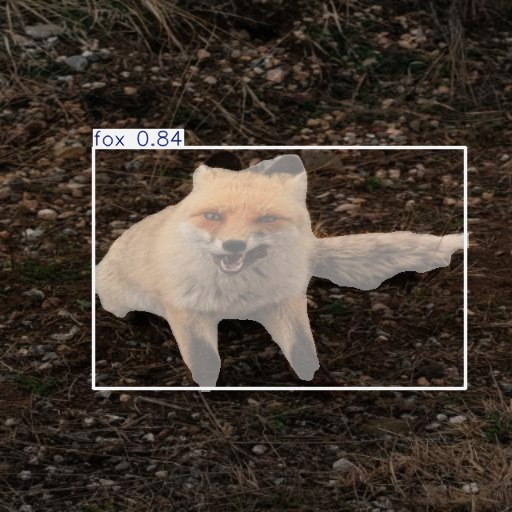

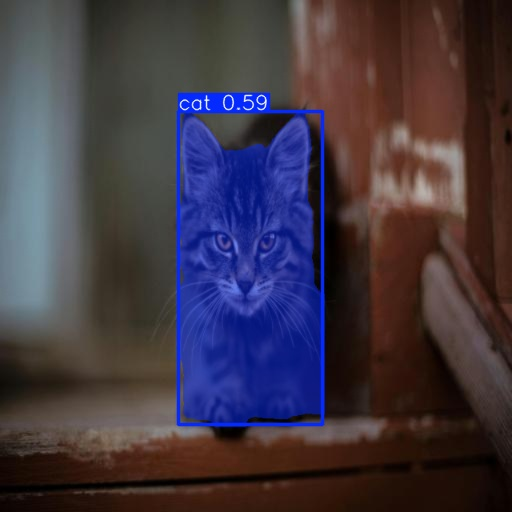

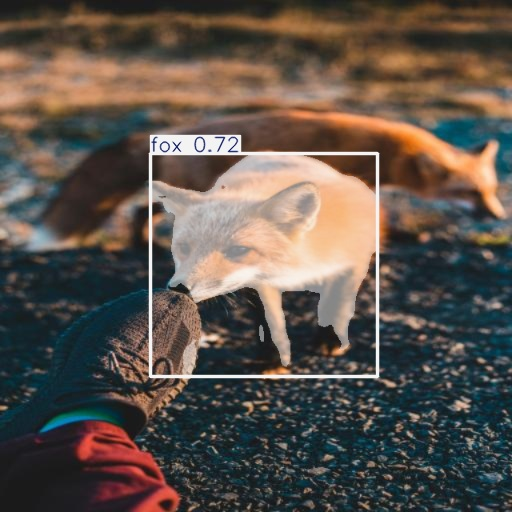

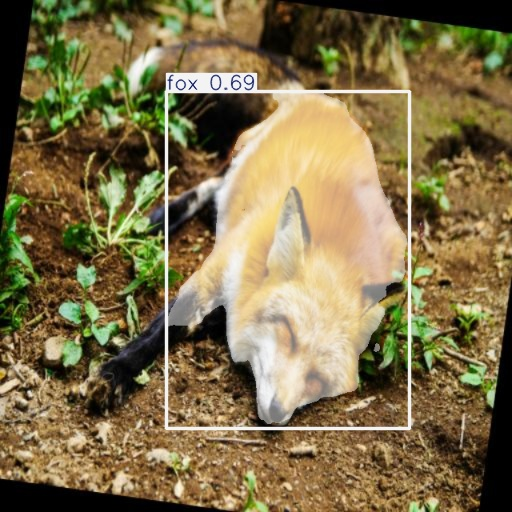

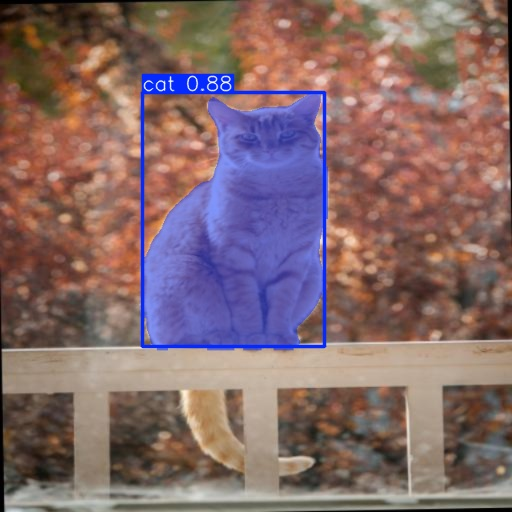

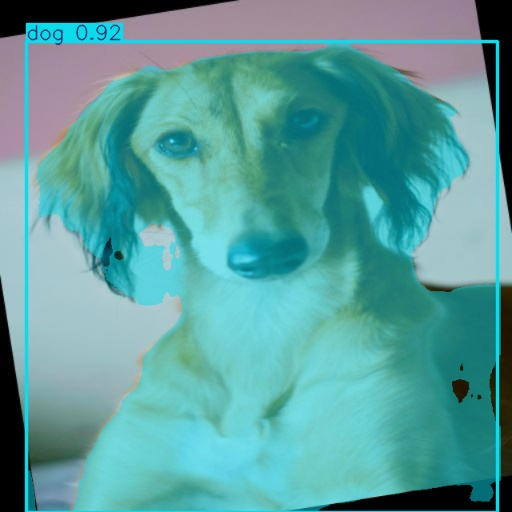

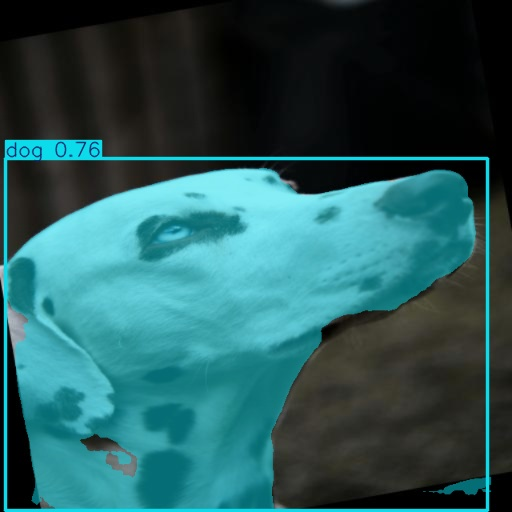

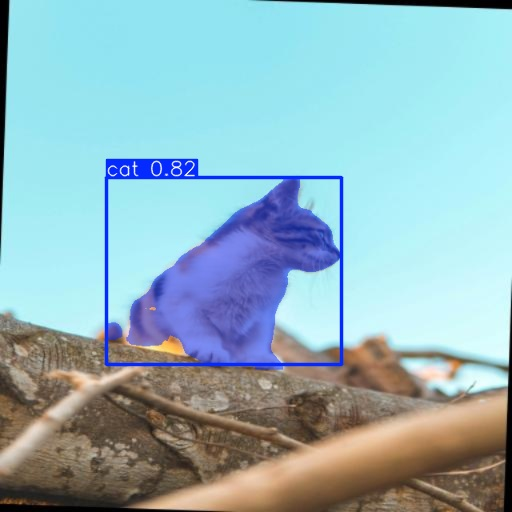

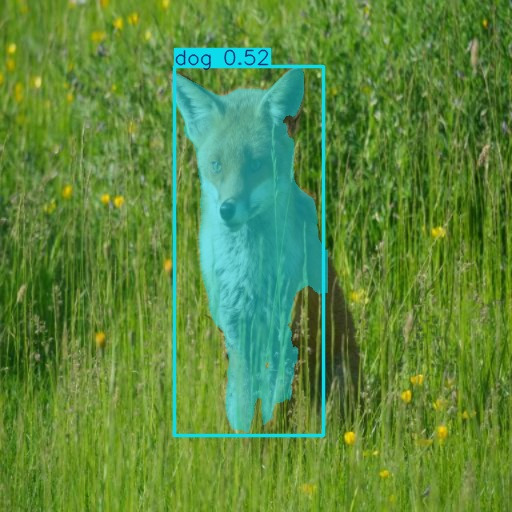

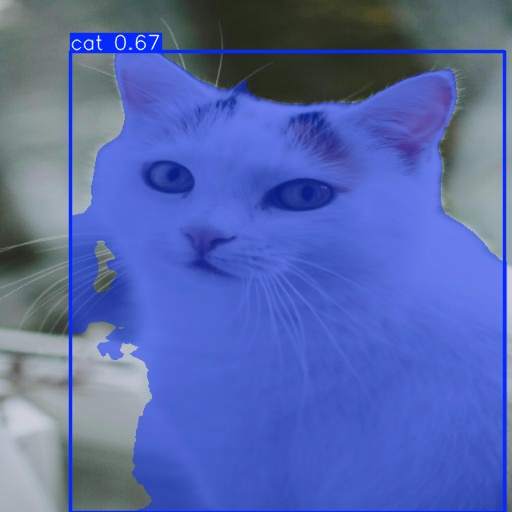

In [14]:
import glob
import random

from IPython.display import Image, display

# Get all image paths
image_paths = glob.glob(f'{HOME}/runs/segment/predict/*.jpg')

# Select up to 20 random images
random_images = random.sample(image_paths, min(len(image_paths), 10))

# Display the selected images
for image_path in random_images:
    display(Image(filename=image_path, width=600))

## Conclusion

This notebook is a simple example of how to train a YOLOv12 segmentation model using the Ultralytics library. You can use this as a starting point for your own projects.

The model is trained on the exported dataset from Oslo and the results are visualized. 

You can find the model weights and the training results in the `runs` folder. Generally `best.pt` is the best model and `results.png` gives you information on how the training went.

In general, the results are reasonable but it would be worth trying to get some pre-trained weights to use as a starting point for training.